In [5]:
import torch
from typing import Tuple
import pandas as pd
import matplotlib.pyplot as plt


# Q1

In [6]:

def gd_factorise_ad(A: torch.Tensor, rank: int, num_epochs=1000, lr=0.01) -> Tuple[torch.Tensor, torch.Tensor]:
    m, n = A.shape
    U = torch.rand((m, rank), requires_grad=True)
    V = torch.rand((n, rank), requires_grad=True)
    # compute loss 
    loss = torch.nn.MSELoss(reduction='sum')
    for i in range(num_epochs):
        U.grad = None
        V.grad = None
        z = loss(A, U @ V.T)
        z.backward()
        U.data = U - lr * U.grad
        V.data = V - lr * V.grad
 
    return U, V


In [7]:
A = torch.tensor([
    [0.3374, 0.6005, 0.1735],
    [3.3359, 0.0492, 1.8374],
    [2.9407, 0.5301, 2.2620]
])

# reconstruction
U, V = gd_factorise_ad(A, 2)

A_G = U @ V.T

# loss 
print('loss:', torch.trace((A - A_G) @ (A - A_G).T))

# or 
loss = torch.nn.MSELoss(reduction='sum')
print('loss:', loss(A, A_G))



loss: tensor(0.1222, grad_fn=<TraceBackward>)
loss: tensor(0.1222, grad_fn=<MseLossBackward>)


# Q2

In [8]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

# centered
data = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)

data = data - data.mean(dim=0)


In [9]:
# 1. reconstruction
U_hat, V_hat = gd_factorise_ad(data, 2)

data_ad = U_hat @ V_hat.T

# loss 
print('loss:', torch.trace((data - data_ad) @ (data - data_ad).T))

# or 
loss = torch.nn.MSELoss(reduction='sum')
print('loss:', loss(data, data_ad))


loss: tensor(15.2289, grad_fn=<TraceBackward>)
loss: tensor(15.2289, grad_fn=<MseLossBackward>)


In [10]:
# 2. truncated svd
U, S, V = torch.svd(data)

# reconstruction
S[-2:] = 0
data_hat = U @ torch.diag(S) @ V.T

# loss 
print('loss:', torch.trace((data - data_hat) @ (data - data_hat).T))

# or 
loss = torch.nn.MSELoss(reduction='sum')
print('loss:', loss(data, data_hat))


loss: tensor(15.2288)
loss: tensor(15.2288)


# Q3

Text(0, 0.5, 'Principal Component 2')

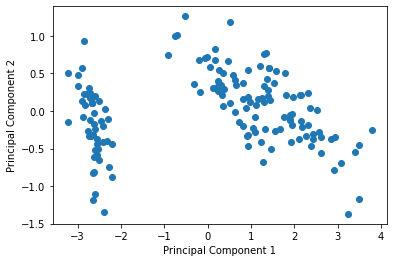

In [20]:
U_P = U@torch.diag(S)
plt.scatter(U_P[:, 0], U_P[:, 1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


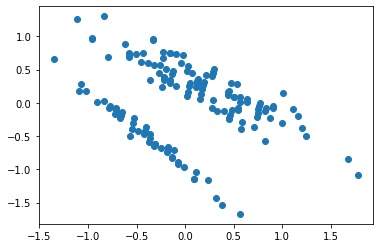

In [33]:
U_hat_P = U_hat.detach().numpy()

plt.scatter(U_hat_P[:, 0], -U_hat_P[:, 1])


# Q4

In [70]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

df = df.sample(frac=1) #shuffle


In [71]:
# categorical target
mapping = {k: v for v, k in enumerate(df[4].unique())}

df[5] = df[4].map(mapping)

mapping


{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

In [75]:
df.head()

,0,1,2,3,4,5
8,4.4,2.9,1.4,0.2,Iris-setosa,0
93,5.0,2.3,3.3,1.0,Iris-versicolor,1
136,6.3,3.4,5.6,2.4,Iris-virginica,2
67,5.8,2.7,4.1,1.0,Iris-versicolor,1
18,5.7,3.8,1.7,0.3,Iris-setosa,0


In [82]:
# predictor
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float)

# standalization
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

alldata.shape, alldata[:3]


(torch.Size([150, 4]),
 tensor([[-2.1049, -0.8191, -0.7576, -1.7147],
         [-1.2299, -4.0106, -0.1473, -0.3411],
         [ 0.6660,  1.8404,  0.5915,  2.0627]]))

In [91]:
# split train and test
y_train = torch.tensor(df.iloc[:100, 5].values, dtype=torch.long)
X_train = alldata[:100]

y_test = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long)
X_test = alldata[100:]

X_train.shape, X_test.shape

(torch.Size([100, 4]), torch.Size([50, 4]))

In [76]:
def gradient_descent(X_train, y_train, num_epochs=100, lr = 0.01):
    W1 = torch.randn((4, 12), requires_grad=True)
    W2 = torch.randn((12, 3), requires_grad=True)

    b1 = torch.tensor(0.0, requires_grad=True)
    b2 = torch.tensor(0.0, requires_grad=True)

    for i in range(num_epochs):
        W1.grad = None
        W2.grad = None
        b1.grad = None
        b2.grad = None

        logits = torch.relu(X_train @ W1 + b1) @ W2 + b2
        z = torch.nn.functional.cross_entropy(logits, y_train)
        z.backward()

        W1.data = W1 - lr * W1.grad
        W2.data = W2 - lr * W2.grad
        b1.data = b1 - lr * b1.grad
        b2.data = b2 - lr * b2.grad

    return W1, W2, b1, b2


(0.7285, 0.791)

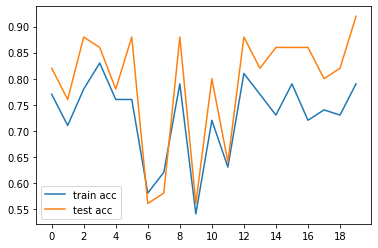

In [115]:
train_acc = []
test_acc = []
iters=20
for i in range(iters):
    W1, W2, b1, b2 = gradient_descent(X_train, y_train)

    y_train_hat = torch.relu(X_train @ W1 + b1) @ W2 + b2
    y_test_hat = torch.relu(X_test @ W1 + b1) @ W2 + b2

    train_acc.append((torch.argmax(y_train_hat, dim=1) == y_train).sum() / len(y_train))
    test_acc.append((torch.argmax(y_test_hat, dim=1) == y_test).sum() / len(y_test))

plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()
plt.xticks(np.arange(0, iters, step=2))

np.mean(train_acc), np.mean(test_acc)
